In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':14})
from matplotlib.lines import Line2D
import cmocean.cm as cm
import os
import re
import math

In [2]:
def load_files(path):
    itimes = {}

    files = [f for f in os.listdir(path) if f.endswith(".log")]
    files.sort()

    for file in files:
        base = file.replace(".log", "")
        parts = base.split("_")

        grid_len = parts[0]
        nodes = parts[1]
        layout = parts[2]
        config_string = f"{nodes} nodes, {layout} gpus"

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

        nt = None
        wt = None

        # Search for iteration count and wall clock time
        for i, line in enumerate(lines):
            if "number of iterations in model run:" in line:
                nt = int(line.split()[-1])

            if "time for model run:" in line:
                wt = float(re.findall(r"[\d.]+", line)[0])

        # Skip only if the run time is missing
        if wt is None:
            continue

        mean_time = wt / nt

        if grid_len not in itimes:
            itimes[grid_len] = {}

        itimes[grid_len][config_string] = mean_time

    return itimes

In [3]:
def compare_grids(path, path_m=None):
    itimes = load_files(path)

    fig, ax = plt.subplots(figsize=(9, 5))

    grid_keys = sorted(itimes.keys(), key=lambda x: int(x))
    color_map = {grid: f'C{i}' for i, grid in enumerate(grid_keys)}

    # Collect all unique layouts that appear in the data (for labeling only)
    all_layouts = set()
    for results in itimes.values():
        for config in results.keys():
            layout_str = config.split(', ')[1].split(' gpus')[0]
            all_layouts.add(layout_str)

    # Use a dot for all points
    marker = '.'

    # Plot each point
    for grid in grid_keys:
        results = itimes[grid]
        color = color_map[grid]

        for config in results.keys():
            # Parse number of nodes
            n_nodes_str = config.split(' nodes')[0]
            n_nodes = int(n_nodes_str)

            # Parse GPU layout (e.g., "1x4")
            layout_str = config.split(', ')[1].split(' gpus')[0]

            # Calculate total number of GPUs
            rows, cols = map(int, layout_str.split('x'))
            n_gpus = rows * cols

            time_val = results[config]

            # Plot point with dot marker
            ax.plot(n_gpus, time_val,
                    marker=marker, color=color, linestyle='None', markersize=8,
                    markeredgewidth=1.2)

            # Label: e.g., "1n, 1x4"
            label = f"{n_nodes}n, {layout_str}"
            ax.text(n_gpus, time_val, label, fontsize=8, ha='left', va='center',
                    color=color, alpha=0.9,
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))


    ##### mitgcm #####
    if path_m:
        # read iteration times mitgcm
        itimes = {}
        
        files = os.listdir(path_m)
        files = [file for file in files if 'output_' in file]
        def get_numbers(filename):
            return [int(n) for n in re.findall(r'\d+', filename)]
        files = sorted(files, key=get_numbers)
        
        search_for="SEAICE_MODEL    [DO_OCEANIC_PHYS]"
        for file in files:
            grid_len = file.split('_')[1]
            nproc = int(file.split('_')[2])
        
            with open(path_m + file) as f:
                
                lines = f.readlines()
                for i, line in enumerate(lines):
                    if line.find("nTimeSteps = ") != -1:
                        ntimesteps_line = lines[i+1]
                    if line.find(search_for) != -1:
                        wall_clock_line = lines[i+3]
            
            ntimesteps = int(ntimesteps_line[:-1].split(' ')[-1])
            wall_clock_time = float(wall_clock_line[:-1].split(' ')[-1])
        
            if grid_len not in itimes:
                itimes[grid_len] = {}
            
            itimes[grid_len][f'{nproc}'] = wall_clock_time / ntimesteps
    
        # plot mitgcm
        for i, key in enumerate(itimes):
            #if i==0: continue
            runtimes_grid = itimes[f'{key}']
        
            nprocs = [int(nproc) for nproc in runtimes_grid.keys()]
            values = list(runtimes_grid.values())
            ax.plot(nprocs, values, 'o-', color=f'C{i}', label=f'MITgcm, grid length = {key}')

    # Finalize plot
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Mean time per iteration /s')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='major', alpha=0.8)
    ax.grid(True, which='minor', alpha=0.5)

    def human_readable(n):
        units = ["", "K", "M", "B", "T"]
        k = 1000.0
    
        magnitude = int(math.log(n, k))
        value = n / k**magnitude
    
        # round to 2 significant digits and remove decimals
        value = round(value, 1)
        value = int(value) if value >= 10 else value
    
        return f"{value}{units[magnitude]}"
        
    grid_legend_handles = [
        Line2D([0], [0], color=f'{color_map[g]}', lw=2, label=human_readable(int(g)**2)) for g in grid_keys
    ]
    legend1 = ax.legend(handles=grid_legend_handles, title='Problem size', loc='center left', bbox_to_anchor=(1, 0.8))

    fig.tight_layout()
    plt.show()

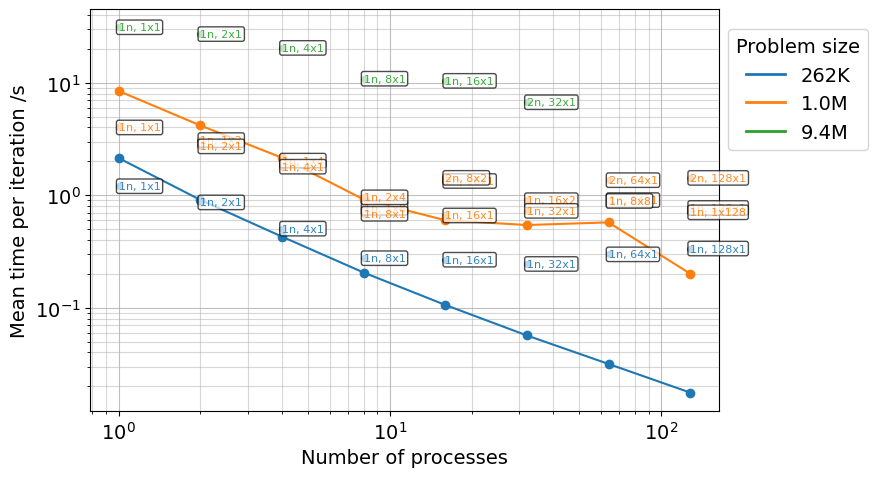

In [4]:
compare_grids('out_cpu/out/',
             '/home/a/a270230/benchmarks/mitgcm_benchmarks/benchmark_results/parallel/one_node_n120/')

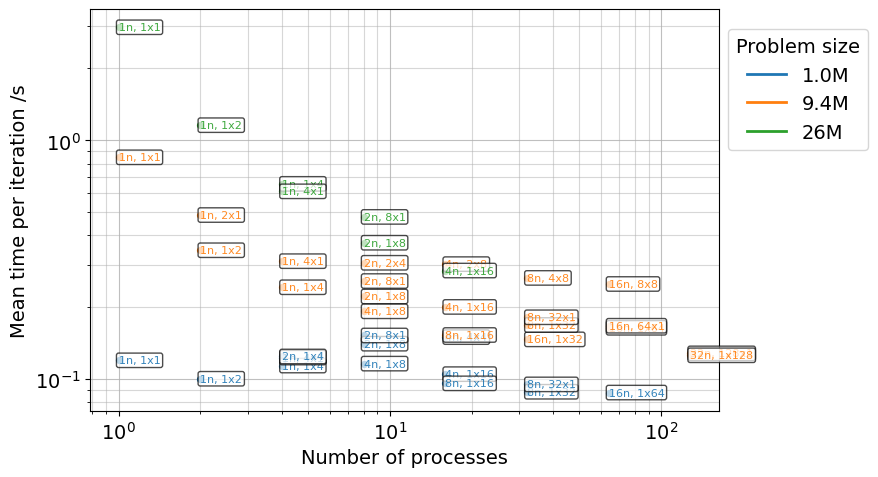

In [5]:
compare_grids('out_gpu/out/')